<a href="https://colab.research.google.com/github/EZ6990/DeepLearning/blob/master/KaggleHomeDepot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir .kaggle
import json
token = {"username":"bgudltaldanny","key":"65b62f1a36c14c834b4e88037463a4f8"}
with open('.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

!touch ~/.kaggle/kaggle.json
!ls -la ~/.kaggle/kaggle.json
!cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 0 Feb  8 21:39 /root/.kaggle/kaggle.json


In [0]:
!kaggle competitions download -c home-depot-product-search-relevance
!unzip home-depot-product-search-relevance.zip -d home-depot-product-search-relevance/
!unzip home-depot-product-search-relevance/train.csv.zip -d home-depot-product-search-relevance/
!unzip home-depot-product-search-relevance/test.csv.zip -d home-depot-product-search-relevance/

 94% 65.0M/69.4M [00:01<00:00, 25.0MB/s]
100% 69.4M/69.4M [00:01<00:00, 42.6MB/s]
Archive:  home-depot-product-search-relevance.zip
  inflating: home-depot-product-search-relevance/attributes.csv.zip  
  inflating: home-depot-product-search-relevance/product_descriptions.csv.zip  
  inflating: home-depot-product-search-relevance/relevance_instructions.docx  
  inflating: home-depot-product-search-relevance/sample_submission.csv.zip  
  inflating: home-depot-product-search-relevance/test.csv.zip  
  inflating: home-depot-product-search-relevance/train.csv.zip  
Archive:  home-depot-product-search-relevance/train.csv.zip
  inflating: home-depot-product-search-relevance/train.csv  
Archive:  home-depot-product-search-relevance/test.csv.zip
  inflating: home-depot-product-search-relevance/test.csv  


In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout,Conv1D, MaxPool1D,Concatenate, LSTM, Reshape, CuDNNLSTM, Embedding, BatchNormalization,Activation
from keras.optimizers import RMSprop
import keras.backend as K
from sklearn.pipeline import Pipeline,FeatureUnion,make_pipeline
from sklearn.preprocessing import FunctionTransformer,KBinsDiscretizer,OneHotEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict,cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.regularizers import l2
from scipy import spatial

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
path='./home-depot-product-search-relevance'
train=pd.read_csv(path+'/train.csv',encoding="Latin-1")

In [3]:
train.head()
train['norm_relevance'] = (train['relevance'] - 1) / 2
train.head()

,id,product_uid,product_title,search_term,relevance,norm_relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,1.000
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,0.750
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,1.000
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,0.665
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,0.835


In [0]:
max_product_title_len=train.product_title.map(lambda x: len(x)).max()
max_search_term=train.search_term.map(lambda x: len(x)).max()
max_input_len=max(max_product_title_len,max_search_term)

In [0]:
class MyCharGenerator(Sequence):
  def __init__(self,padding,df,batch_size=32,char_value=0):
    self.padding=padding
    self.char_value=char_value
    self.df=df
    self.batch_size=batch_size


  def __iter__(self):
    while(True):
      X1 = []
      X2 = []
      y = []

      for index,row in self.df.iterrows():
        y.append(row['norm_relevance'])
        st_list= [ord(c) for c in list(row['search_term'])]
        pt_list=[ord(c) for c in list(row['product_title'])]
        #X1.append(np.pad(st_list,(0,self.padding-len(st_list))))
        #X2.append(np.pad(pt_list,(0,self.padding-len(pt_list))))
        X1.append(np.reshape(np.pad(st_list,(0,self.padding-len(st_list))),(147,1)))
        X2.append(np.reshape(np.pad(pt_list,(0,self.padding-len(pt_list))),(147,1)))
        # assume there's one document per line, tokens separated by whitespace
        if (index + 1) % self.batch_size == 0:
          y=np.array(y)

          yield (np.array([X1,X2]),y)
          X1 = []
          X2 = []
          y=[]

      y=np.array(y)
      if(len(y) > 0):
        yield np.array([X1,X2]),y


In [0]:
class MyWordGenerator(Sequence):
  def __init__(self,padding,df,batch_size=32,char_value=0):
    self.padding=padding
    self.df=df
    self.batch_size=batch_size
    self.words_dictonary = {}


  def __iter__(self):
    while(True):
      X1 = []
      X2 = []
      y = []

      for index,row in self.df.iterrows():
        y.append(row['norm_relevance'])
        st_list = []
        for word in row['search_term'].split(' '):
          if not (word in self.words_dictonary):
            self.words_dictonary[word] = len(self.words_dictonary)
          st_list.append(self.words_dictonary[word])
            
        pt_list = []
        for word in row['product_title'].split(' '):
          if not (word in self.words_dictonary):
            self.words_dictonary[word] = len(self.words_dictonary)
          pt_list.append(self.words_dictonary[word])

        X1.append(np.reshape(np.pad(st_list,(0,self.padding-len(st_list))),(self.padding,1)))
        X2.append(np.reshape(np.pad(pt_list,(0,self.padding-len(pt_list))),(self.padding,1)))
        # assume there's one document per line, tokens separated by whitespace
        if (index + 1) % self.batch_size == 0:
          y=np.array(y)

          yield (np.array([X1,X2]),y)
          X1 = []
          X2 = []
          y=[]

      y=np.array(y)
      if(len(y) > 0):
        yield np.array([X1,X2]),y


def rmse(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def our_mse(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true), axis=-1)

loss_index = 0
def new_loss(y_actual,y_predicted):
  global loss_index
  global y_train
  global X1_train
  global X2_train

  cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)
  loss = tf.constant(0.0)
  m = tf.constant(-0.00015)
  x = tf.constant(0.0)
  K.switch(tf.constant(y_train[x]))
  loss = tf.add(loss,tf.subtract(tf.constant(1.0),
                                  cosine_loss(np.float32(X1_train[loss_index+i]),np.float32(X2_train[loss_index+i]))))
  loss_index+=32
  with open('log.log', 'a') as file:
    json.dump(loss_index, file)
  tf.Print(loss,[loss],("%s" %loss_index))
  #return tf.add(K.sum(tf.multiply(tf.constant(0.0),y_predicted)),loss)
  return cosine_loss(y_actual,y_predicted)

# siames_model=network(max_input_len)
# siames_model.summary()
# siames_model.compile(loss=new_loss ,optimizer='adam',metrics=['mae','accuracy'])
# model_hist = siames_model.fit([X1_train,X2_train],y_train,verbose=2,epochs=3,batch_size=32,validation_data=([X1_test,X2_test],y_test))


## Siamese network from the article

In [0]:
def network(n_fetures,n_described=1):
  inp=Input(shape=(n_fetures,n_described))
  x = CuDNNLSTM(n_fetures)(inp)
  x = Reshape((n_fetures,1))(x)
  x=Conv1D(filters=32,kernel_size=10,activation='relu')(x)
  x=MaxPool1D()(x)
  x=Conv1D(filters=64,kernel_size=10,activation='relu')(x)
  x=MaxPool1D()(x)
  x=Conv1D(filters=128,kernel_size=10,activation='relu')(x)
  x=Flatten()(x)
  x=Dense(128,activation='relu')(x)
  model= Model(inp,x)

  search_term_input=Input(shape=(n_fetures,n_described),name='inp1')
  product_title_input=Input(shape=(n_fetures,n_described),name='inp2')

  search_term_encoded=model(search_term_input)
  product_title_encoded=model(product_title_input)


  x_connected=Concatenate()([search_term_encoded,product_title_encoded])
  x_connected=Dense(1,activation='sigmoid')(x_connected)
  
  
  connected_model=Model(inputs=[search_term_input,product_title_input],output=x_connected)
  connected_model.summary()

  return connected_model


## Prepare the data

In [0]:
myGen=MyCharGenerator(padding=147,df=train,batch_size=1)
it = iter(myGen)

X1 = []
X2 = []
Y = []
for time in range(len(train)):
  [X1_gen,X2_gen],y_gen = next(it)
  X1.append([X for X in X1_gen[0]])
  X2.append([X for X in X2_gen[0]])
  Y.append(y_gen[0])

X1_train,X1_test,X2_train,X2_test,y_train,y_test = train_test_split(X1,X2,Y,test_size=0.2)

X1_train = np.array(X1_train)
X2_train = np.array(X2_train)
y_train = np.array(y_train)
X1_test = np.array(X1_test)
X2_test = np.array(X2_test)
y_test = np.array(y_test)


##Character level LSTM

In [9]:
siames_model=network(max_input_len)
# siames_model.summary()
siames_model.compile(loss=our_mse ,optimizer='adam',metrics=['mae','accuracy',rmse])





Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               (None, 147, 1)       0                                            
__________________________________________________________________________________________________
inp2 (InputLayer)               (None, 147, 1)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          535336      inp1[0][0]                       
                                                                 inp2[0][0]                       
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           model_1[1][0]          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [10]:
model_hist = siames_model.fit([X1_train,X2_train],y_train,verbose=2,epochs=5,batch_size=20,validation_data=([X1_test,X2_test],y_test))




Train on 59253 samples, validate on 14814 samples
Epoch 1/5





 - 58s - loss: 0.0721 - mean_absolute_error: 0.2201 - acc: 0.2589 - rmse: 0.2201 - val_loss: 0.0716 - val_mean_absolute_error: 0.2200 - val_acc: 0.2552 - val_rmse: 0.2200
Epoch 2/5
 - 54s - loss: 0.0717 - mean_absolute_error: 0.2193 - acc: 0.2590 - rmse: 0.2193 - val_loss: 0.0706 - val_mean_absolute_error: 0.2173 - val_acc: 0.2552 - val_rmse: 0.2173
Epoch 3/5
 - 54s - loss: 0.0716 - mean_absolute_error: 0.2192 - acc: 0.2590 - rmse: 0.2192 - val_loss: 0.0706 - val_mean_absolute_error: 0.2173 - val_acc: 0.2552 - val_rmse: 0.2173
Epoch 4/5
 - 54s - loss: 0.0716 - mean_absolute_error: 0.2192 - acc: 0.2590 - rmse: 0.2192 - val_loss: 0.0706 - val_mean_absolute_error: 0.2174 - val_acc: 0.2552 - val_rmse: 0.2174
Epoch 5/5
 - 54s - loss: 0.0715 - mean_absolute_error: 0.2192 - acc: 0.2590 - rmse: 0.2192 - val_loss: 0.0706 - val_mean_absolute_error: 0.2173 - val_acc: 0.2552 - val_rmse: 0.2173


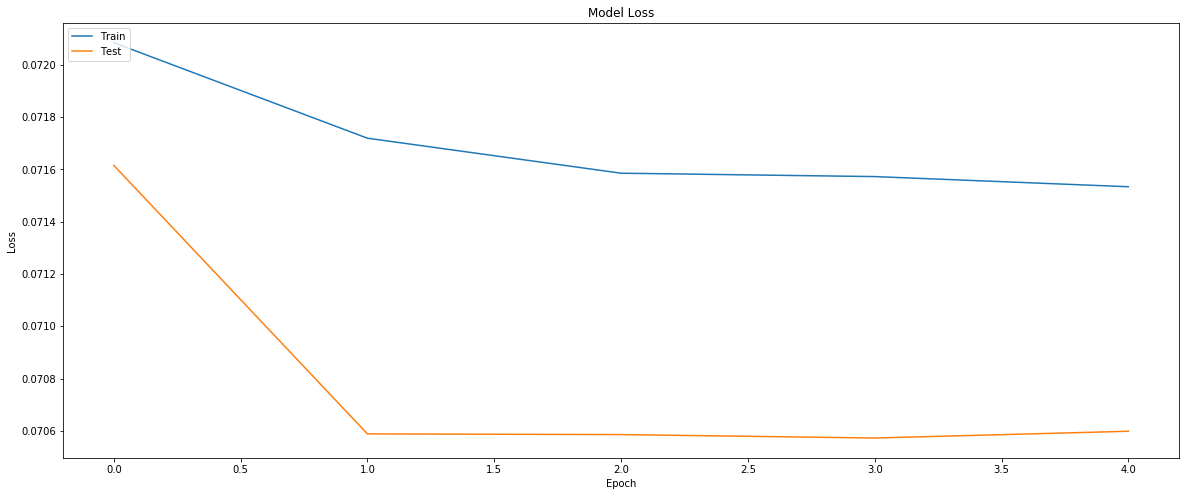

In [11]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(model_hist.history['loss'])
ax.plot(model_hist.history['val_loss'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Naive model- Vectorizer

In [0]:
def get_query(X):
  return pd.DataFrame(X,columns=['query','title'])['query'].values
def get_title(X):
  return pd.DataFrame(X,columns=['query','title'])['title'].values

Naive_X = []
Naive_Y = []

for index,row in train.iterrows():
  Naive_Y.append(row['relevance'])
  Naive_X.append([''.join(list(row['search_term'])),''.join(list(row['product_title']))])

X_naive_train,X_naive_test,y_naive_train,y_naive_test = train_test_split(Naive_X,Naive_Y,test_size=0.2)

pipeline = Pipeline(
    [
     ('fetures',
         FeatureUnion(
             [
                 ('later',
                  Pipeline(
                      [
                          ('query',FunctionTransformer(get_query)),
                          ('vect', CountVectorizer(stop_words=[' '], max_df=0.5, max_features=5000,lowercase=False,analyzer='char'))
                      ]
                  )),
                 ('bins',
                  Pipeline(
                      [
                       ('title',FunctionTransformer(get_title)),
                       ('vect', CountVectorizer(stop_words=[' '], max_df=0.5, max_features=5000,lowercase=False,analyzer='char'))
                      ]
                  )
                 )
             ]
         )
      ),
     ('clf', LinearRegression()),
    ]
)
naive_model = cross_validate(pipeline, X_naive_train, y_naive_train, cv=5,return_estimator=True,return_train_score=True,scoring='neg_mean_squared_error')
best_estimator = np.argmax(naive_model['test_score'])
predictions = naive_model['estimator'][best_estimator].predict(X_naive_test)
mae = np.absolute((np.array(y_naive_test)-np.array(predictions))).mean()


rmse = math.sqrt(((np.array(y_naive_test)-np.array(predictions))**2).mean())
print("MAE: %.3f" %mae)
print("RMSE: %.3f" %rmse)

MAE: 0.435
RMSE: 0.531


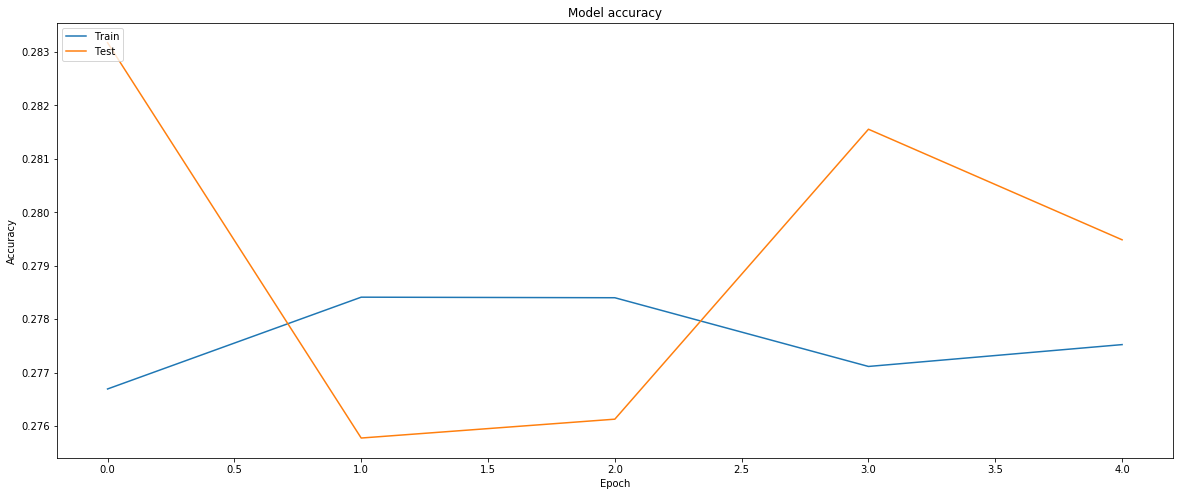

In [0]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-naive_model['train_score'])
ax.plot(-naive_model['test_score'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Transfer Learning to classical ML

In [0]:
%%time

siames_model_ML = Model(siames_model.input,siames_model.layers[-2].output)
siames_model_ML.compile(loss='mse',optimizer='SGD')
siames_model_ML.summary()


ml_predictions_train = siames_model_ML.predict([X1_train,X2_train])
ml_predictions_test = siames_model_ML.predict([X1_test,X2_test])


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               (None, 147, 1)       0                                            
__________________________________________________________________________________________________
inp2 (InputLayer)               (None, 147, 1)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          535336      inp1[0][0]                       
                                                                 inp2[0][0]                       
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256)          0           model_1[1][0]              

##KNN

In [0]:
%%time

ml_knn_model = KNeighborsRegressor(n_jobs=16,weights='distance',algorithm='ball_tree',n_neighbors=3)
ml_knn_estimators = cross_validate(ml_knn_model, ml_predictions_train, y_train*2+1, cv=5,return_estimator=True,return_train_score=True,scoring='neg_mean_squared_error')
best_estimator = np.argmax(ml_knn_estimators['test_score'])
ml_knn_predictions = ml_knn_estimators['estimator'][best_estimator].predict(ml_predictions_test)

y_t=np.array(y_test)*2+1
mae_knn = np.absolute((y_t-np.array(ml_knn_predictions))).mean()
rmse_knn = math.sqrt(((y_t-np.array(ml_knn_predictions))**2).mean())

print("KNN MAE: %.3f" %mae_knn)
print("KNN RMSE: %.3f" %rmse_knn)


KNN MAE: 0.491
KNN RMSE: 0.617
CPU times: user 27 s, sys: 1.88 s, total: 28.9 s
Wall time: 3min 55s


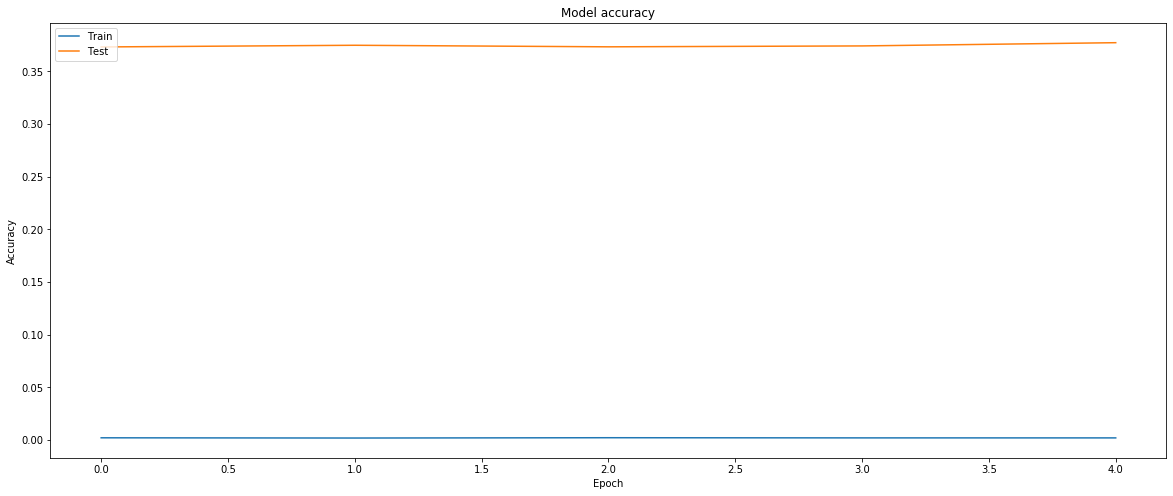

In [0]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-ml_knn_estimators['train_score'])
ax.plot(-ml_knn_estimators['test_score'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Random forest

In [0]:
%%time

ml_rf_model = RandomForestRegressor(n_jobs=16,min_samples_leaf=2, max_depth =3,n_estimators=5)
ml_rf_estimators = cross_validate(ml_rf_model, ml_predictions_train, y_train*2+1, cv=5,return_estimator=True,return_train_score=True,scoring='neg_mean_squared_error')
best_estimator = np.argmax(ml_rf_estimators['test_score'])
ml_rf_predictions = ml_rf_estimators['estimator'][best_estimator].predict(ml_predictions_test)

y_t_rf=y_test*2+1

mae_rf = np.absolute((np.array(y_t_rf)-np.array(ml_rf_predictions*2+1))).mean()
rmse_rf = math.sqrt(((np.array(y_t_rf)-np.array(ml_rf_predictions*2+1))**2).mean())


print("RANDOM MAE: %.3f" %mae_rf)
print("RANDOM RMSE: %.3f" %rmse_rf)

RANDOM MAE: 3.380
RANDOM RMSE: 3.421
CPU times: user 488 ms, sys: 127 ms, total: 616 ms
Wall time: 4.83 s


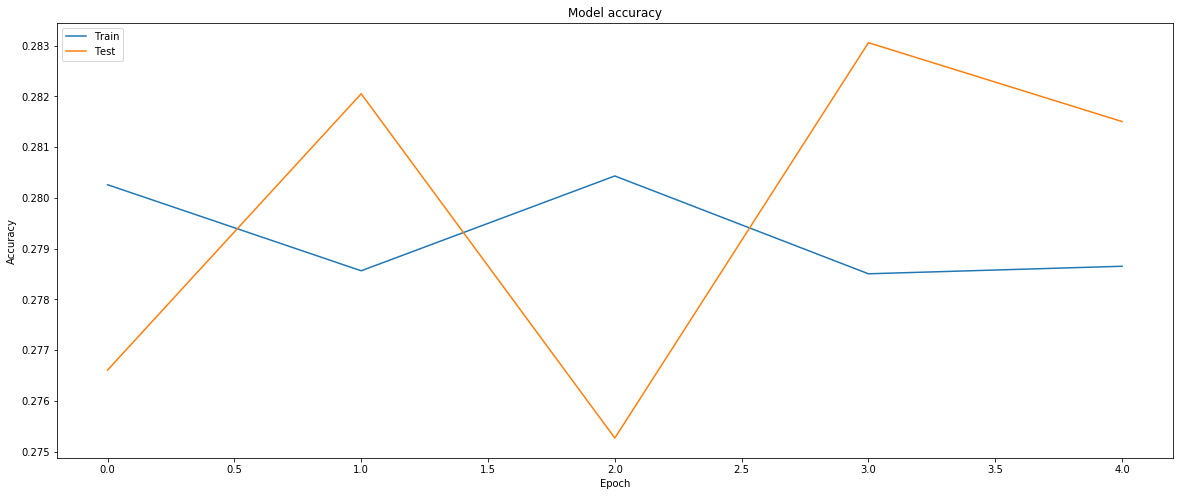

In [0]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-ml_rf_estimators['train_score'])
ax.plot(-ml_rf_estimators['test_score'])
ax.set_title('Model accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

We explored the data and decided we need to do some preprocessing

we found some examples for words that ment the same thing but were wrote differently.

for example in the 'product title' column there is no 'inches' there is 'in.'
but in the 'search term' there is 'inches'

In [12]:
 print ('\'product_titles\' contains \'inches\'')
 display(train.loc[train['product_title'].str.contains(' inches ')])
 print ('\n\n\n\'search_terms\' contains \'inches\'')
 display(train.loc[train['search_term'].str.contains(' inches ')].head(5))

'product_titles' contains 'inches'


,id,product_uid,product_title,search_term,relevance,norm_relevance





'search_terms' contains 'inches'


,id,product_uid,product_title,search_term,relevance,norm_relevance
4015,12507,102193,Samsung 28.15 cu. ft. 4-Door French Door Refri...,33 inches wide samsung,2.67,0.835
13646,42206,110179,JELD-WEN Smooth 4-Panel Primed Molded Interior...,interior doors 82 inches in length,2.33,0.665
14917,46069,111389,Paslode 3 in. x 0.131-Gauge 30å¡ Brite Smooth ...,3 .5 inches paper tape collated,2.00,0.500
15609,48121,112069,Roberts Laminate Cutter for Cross Cutting up t...,metric to inches converter,1.67,0.335
17099,52792,113648,Masonite 30 in. x 80 in. Textured 6-Panel Holl...,interior doors 82 inches in length,2.67,0.835


In [0]:
import re
def preprocess_sentences(s):
  s = s.lower()
  s = re.sub(r"(\d+)'",r'\1in.',s)
  s = s.replace("inches","in.") 
  s = s.replace("inch","in.")
  s = s.replace(" in ","in. ") 
  s = s.replace(" in.","in.") 

  s = s.replace("''","ft.") 
  s = s.replace(" feet ","ft. ") 
  s = s.replace("feet","ft.") 
  s = s.replace("foot","ft.") 
  s = s.replace(" ft ","ft. ") 
  s = s.replace(" ft.","ft.") 

  s = s.replace(" pounds ","lb. ")
  s = s.replace(" pound ","lb. ") 
  s = s.replace("pound","lb.") 
  s = s.replace(" lb ","lb. ") 
  s = s.replace(" lb.","lb.") 
  s = s.replace(" lbs ","lb. ") 
  s = s.replace("lbs.","lb.") 

  s = s.replace(" x "," xby ")
  s = s.replace("*"," xby ")
  s = s.replace(" by "," xby")
  s = s.replace("x0"," xby 0")
  s = s.replace("x1"," xby 1")
  s = s.replace("x2"," xby 2")
  s = s.replace("x3"," xby 3")
  s = s.replace("x4"," xby 4")
  s = s.replace("x5"," xby 5")
  s = s.replace("x6"," xby 6")
  s = s.replace("x7"," xby 7")
  s = s.replace("x8"," xby 8")
  s = s.replace("x9"," xby 9")
  s = s.replace("0x","0 xby ")
  s = s.replace("1x","1 xby ")
  s = s.replace("2x","2 xby ")
  s = s.replace("3x","3 xby ")
  s = s.replace("4x","4 xby ")
  s = s.replace("5x","5 xby ")
  s = s.replace("6x","6 xby ")
  s = s.replace("7x","7 xby ")
  s = s.replace("8x","8 xby ")
  s = s.replace("9x","9 xby ")

  s = s.replace(" sq ft","sq.ft. ") 
  s = s.replace("sq ft","sq.ft. ")
  s = s.replace("sqft","sq.ft. ")
  s = s.replace(" sqft ","sq.ft. ") 
  s = s.replace("sq. ft","sq.ft. ") 
  s = s.replace("sq ft.","sq.ft. ") 
  s = s.replace("sq feet","sq.ft. ") 
  s = s.replace("square feet","sq.ft. ") 

  s = s.replace(" gallons ","gal. ") 
  s = s.replace(" gallon ","gal. ") 
  s = s.replace("gallons","gal.") 
  s = s.replace("gallon","gal.") 
  s = s.replace(" gal ","gal. ") 
  s = s.replace(" gal","gal.") 

  s = s.replace("ounces","oz.")
  s = s.replace("ounce","oz.")
  s = s.replace(" oz.","oz. ")
  s = s.replace(" oz ","oz. ")

  s = s.replace("centimeters","cm.")    
  s = s.replace(" cm.","cm.")
  s = s.replace(" cm ","cm. ")
  
  s = s.replace("milimeters","mm.")
  s = s.replace(" mm.","mm.")
  s = s.replace(" mm ","mm. ")
  
  s = s.replace("°","deg. ")
  s = s.replace("degrees","deg. ")
  s = s.replace("degree","deg. ")
  
  s = s.replace("volts","volt. ")
  s = s.replace("volt","volt. ")

  s = s.replace("watts","watt. ")
  s = s.replace("watt","watt. ")

  return s

In [14]:
processed_train = train.copy()
processed_train['search_term'] = processed_train['search_term'].map(lambda x:preprocess_sentences(x))
processed_train['product_title'] = processed_train['product_title'].map(lambda x:preprocess_sentences(x))

print ('\'product_titles\' contains \'inches\'')
display(processed_train.loc[processed_train['product_title'].str.contains(' in. ')])
print ('\n\n\n\'search_terms\' contains \'inches\'')
display(processed_train.loc[processed_train['search_term'].str.contains(' in. ')].head(5))

'product_titles' contains 'inches'


,id,product_uid,product_title,search_term,relevance,norm_relevance
18498,57112,115108,ready-strip 32oz. environmentally friendly dr...,adhesive slide strip,1.67,0.335
25119,77115,122211,bonded logic inc ultrasonic 12in. xby 12in. ac...,12in. ceiling tile,2.00,0.500
25120,77121,122211,bonded logic inc ultrasonic 12in. xby 12in. ac...,sound dampening,2.67,0.835
25121,77123,122211,bonded logic inc ultrasonic 12in. xby 12in. ac...,sounds panels,2.00,0.500
67581,202995,191353,mohawk home ink swirl cocoa 2ft. xby 8ft. runner,rug ruunners,2.00,0.500





'search_terms' contains 'inches'


,id,product_uid,product_title,search_term,relevance,norm_relevance
42161,128340,144629,liberty 20in. european self-closing drawer sli...,18.75 in. drawer slides,2.67,0.835
54368,164835,164764,kaleen matira blue 2ft. xby 3ft. indoor/outdoo...,"kaleen rugs, inc matira area rug 3 x",2.00,0.500
55418,167918,166665,kaleen matira blue 2ft. xby 3ft. indoor/outdoo...,"kaleen rugs, inc matira area rug 3 x",3.00,1.000
60397,182300,176124,kaleen matira blue 3ft. xby 5ft. indoor/outdoo...,"kaleen rugs, inc matira area rug 3 x",3.00,1.000


##Word level LSTM

In [0]:
max_product_title_len=processed_train.product_title.map(lambda x: len(x.split(' '))).max()
max_search_term=processed_train.search_term.map(lambda x: len(x.split(' '))).max()
max_input_len=max(max_product_title_len,max_search_term,70)

In [0]:
myGen=MyWordGenerator(padding=max_input_len,df=processed_train,batch_size=1)
it = iter(myGen)

X1 = []
X2 = []
Y = []
for time in range(len(processed_train)):
  [X1_gen,X2_gen],y_gen = next(it)
  X1.append([X for X in X1_gen[0]])
  X2.append([X for X in X2_gen[0]])
  Y.append(y_gen[0])

X1_train,X1_test,X2_train,X2_test,y_train,y_test = train_test_split(X1,X2,Y,test_size=0.2)

X1_train = np.array(X1_train)
X2_train = np.array(X2_train)
y_train = np.array(y_train)
X1_test = np.array(X1_test)
X2_test = np.array(X2_test)
y_test = np.array(y_test)


##Embedding Training

In [17]:
%%time

def embedding_input(name, n_in, n_out, reg=1e-4):
    inp = Input(shape=(70,1), dtype='int64', name=name)
    x = Flatten()(inp)
    return inp, Embedding(n_in, n_out, input_length=70, embeddings_regularizer=l2(reg))(x)

query_inp,query_emb = embedding_input("query",len(processed_train.search_term.unique()),50)
title_inp,title_emb = embedding_input("title",len(processed_train.product_title.unique()),50)
x = Concatenate()([query_emb,title_emb])
x = Flatten()(x)
x= BatchNormalization()(x)
# x= Activation('relu')(x)
x = Dense(1,activation='relu')(x)
embedding_model = Model([query_inp, title_inp], x)
embedding_model.compile(optimizer='adam', loss='mae',metrics=['accuracy',rmse,'mae'])
embedding_model.summary()


embedding_model_hist = embedding_model.fit([X1_train,X2_train], y_train, batch_size=20, epochs=10, 
          validation_data=([X1_test,X2_test], y_test))


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
title (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 70)           0           query[0][0]                      
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 70)           0           title[0][0]                      
___________________________________________________________________________________________

## Siamese word LSTM

In [18]:
inp=Input(shape=(70,50))
x = CuDNNLSTM(70)(inp)
x = Reshape((70,1))(x)
x=Conv1D(filters=32,kernel_size=10,activation='relu')(x)
x=MaxPool1D()(x)
x=BatchNormalization()(x)
x=Activation('tanh')(x)
x=Conv1D(filters=64,kernel_size=10,activation='relu')(x)
x=MaxPool1D()(x)
x=Conv1D(filters=128,kernel_size=10,activation='relu')(x)
x=BatchNormalization()(x)
x=Activation('tanh')(x)
x=Flatten()(x)
x=Dense(128,activation='relu')(x)
model= Model(inp,x)

search_term_encoded=model(query_emb)
product_title_encoded=model(title_emb)


x_connected=Concatenate()([search_term_encoded,product_title_encoded])
x_connected=Dense(1,activation='sigmoid')(x_connected)

siames_embedded_model = Model([query_inp,title_inp],x_connected)
siames_embedded_model.summary()
siames_embedded_model.compile(loss=our_mse ,optimizer='adam',metrics=['mae','accuracy',rmse])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
title (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 70)           0           query[0][0]                      
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 70)           0           title[0][0]                      
____________________________________________________________________________________________

In [19]:
%%time
word_model_hist = siames_embedded_model.fit([X1_train,X2_train],y_train,verbose=2,epochs=5,batch_size=32,validation_data=([X1_test,X2_test],y_test))

Train on 59253 samples, validate on 14814 samples
Epoch 1/5
 - 40s - loss: 0.0719 - mean_absolute_error: 0.2189 - acc: 0.2561 - rmse: 0.2189 - val_loss: 0.1477 - val_mean_absolute_error: 0.2924 - val_acc: 0.2664 - val_rmse: 0.2924
Epoch 2/5
 - 41s - loss: 0.0721 - mean_absolute_error: 0.2125 - acc: 0.2562 - rmse: 0.2125 - val_loss: 0.0857 - val_mean_absolute_error: 0.2395 - val_acc: 0.2664 - val_rmse: 0.2395
Epoch 3/5
 - 40s - loss: 0.0664 - mean_absolute_error: 0.1999 - acc: 0.2578 - rmse: 0.1999 - val_loss: 0.1536 - val_mean_absolute_error: 0.2929 - val_acc: 0.2664 - val_rmse: 0.2929
Epoch 4/5
 - 41s - loss: 0.0629 - mean_absolute_error: 0.1930 - acc: 0.2614 - rmse: 0.1930 - val_loss: 0.1279 - val_mean_absolute_error: 0.2683 - val_acc: 0.2664 - val_rmse: 0.2683
Epoch 5/5
 - 41s - loss: 0.0615 - mean_absolute_error: 0.1897 - acc: 0.2630 - rmse: 0.1897 - val_loss: 0.1092 - val_mean_absolute_error: 0.2723 - val_acc: 0.2677 - val_rmse: 0.2723
CPU times: user 4min 8s, sys: 20.5 s, total: 

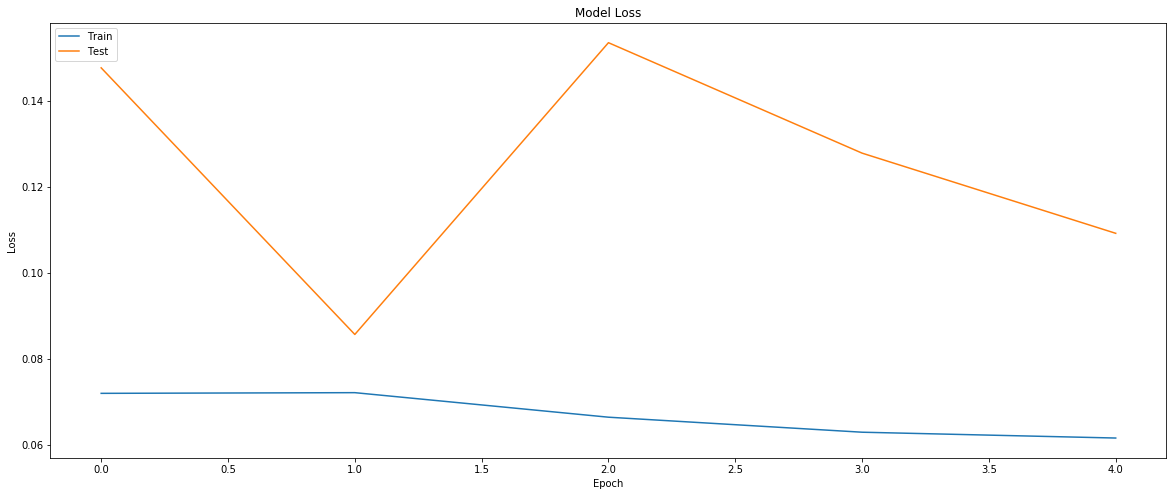

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(word_model_hist.history['loss'])
ax.plot(word_model_hist.history['val_loss'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

## Naive Model- vectorize

In [0]:
def get_query(X):
  return pd.DataFrame(X,columns=['query','title'])['query'].values
def get_title(X):
  return pd.DataFrame(X,columns=['query','title'])['title'].values

Naive_X = []
Naive_Y = []
for index,row in processed_train.iterrows():
  Naive_Y.append(row['relevance'])
  Naive_X.append([row['search_term'],row['product_title']])

X_naive_train,X_naive_test,y_naive_train,y_naive_test = train_test_split(Naive_X,Naive_Y,test_size=0.2)

pipeline = Pipeline(
    [
     ('fetures',
         FeatureUnion(
             [
                 ('later',
                  Pipeline(
                      [
                          ('query',FunctionTransformer(get_query)),
                          ('vect', CountVectorizer(stop_words=[' '], max_df=0.5, max_features=5000,lowercase=False))
                      ]
                  )),
                 ('bins',
                  Pipeline(
                      [
                       ('title',FunctionTransformer(get_title)),
                       ('vect', CountVectorizer(stop_words=[' '], max_df=0.5, max_features=5000,lowercase=False))
                      ]
                  )
                 )
             ]
         )
      ),
     ('clf', LinearRegression()),
    ]
)


naive_word_model = cross_validate(pipeline, X_naive_train ,y_naive_train, cv=3,return_estimator=True,return_train_score=True,scoring='neg_mean_squared_error')
word_best_estimator = np.argmax(naive_word_model['test_score'])
predictions = naive_word_model['estimator'][word_best_estimator].predict(X_naive_test)
mae = np.absolute((np.array(y_naive_test)-np.array(predictions))).mean()
rmse = math.sqrt(((np.array(y_naive_test)-np.array(predictions))**2).mean())
print("MAE: %.3f" %mae)
print("RMSE: %.3f" %rmse)

MAE: 0.426
RMSE: 0.536


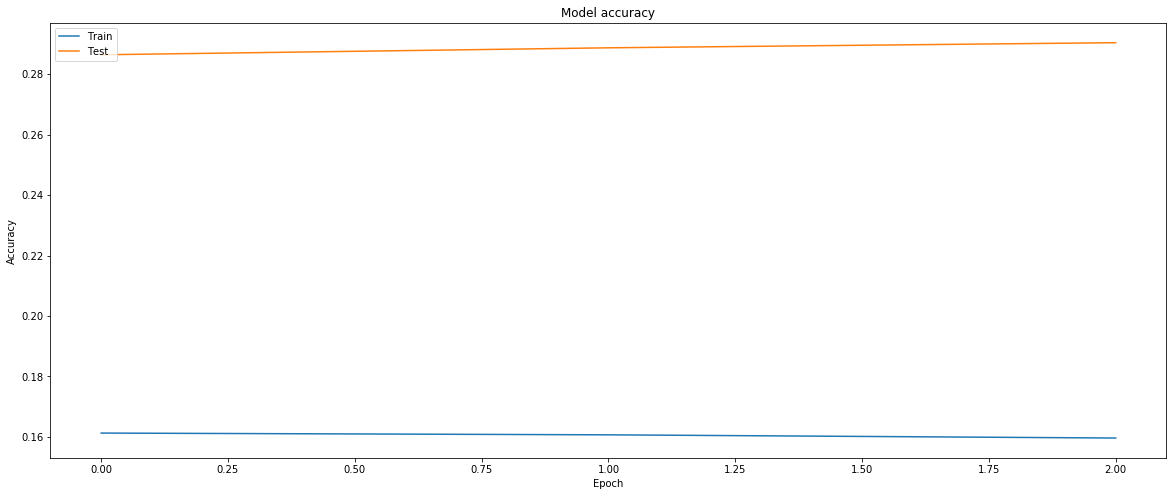

In [0]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-naive_word_model['train_score'])
ax.plot(-naive_word_model['test_score'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Transfer Learning to classical ML


In [0]:

siames_word_model_ML = Model(siames_embedded_model.input,siames_embedded_model.layers[-2].output)
siames_word_model_ML.compile(optimizer='SGD')
siames_word_model_ML.summary()


word_ml_predictions_train = siames_word_model_ML.predict([X1_train,X2_train])
word_ml_predictions_test = siames_word_model_ML.predict([X1_test,X2_test])




Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
query (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
title (InputLayer)              (None, 70, 1)        0                                            
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 70)           0           query[0][0]                      
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 70)           0           title[0][0]                      
____________________________________________________________________________________________

##KNN



In [0]:
%%time

ml_knn_word_model = KNeighborsRegressor(n_jobs=16,weights='distance',algorithm='ball_tree',n_neighbors=3)
ml_knn_word_estimators = cross_validate(ml_knn_word_model, word_ml_predictions_train, y_train*2+1, cv=5,return_estimator=True,return_train_score=True,scoring='neg_mean_squared_error')
best_estimator = np.argmax(ml_knn_word_estimators['test_score'])
word_ml_knn_predictions = ml_knn_word_estimators['estimator'][best_estimator].predict(word_ml_predictions_test)

y_t=np.array(y_test)*2+1

word_mae_knn = np.absolute((y_t-np.array(word_ml_knn_predictions))).mean()
word_rmse_knn = math.sqrt(((y_t-np.array(word_ml_knn_predictions))**2).mean())


print("KNN MAE: %.3f" %word_mae_knn)
print("KNN RMSE: %.3f" %word_rmse_knn)



KNN MAE: 0.439
KNN RMSE: 0.559
CPU times: user 19 s, sys: 1.85 s, total: 20.9 s
Wall time: 2min 20s


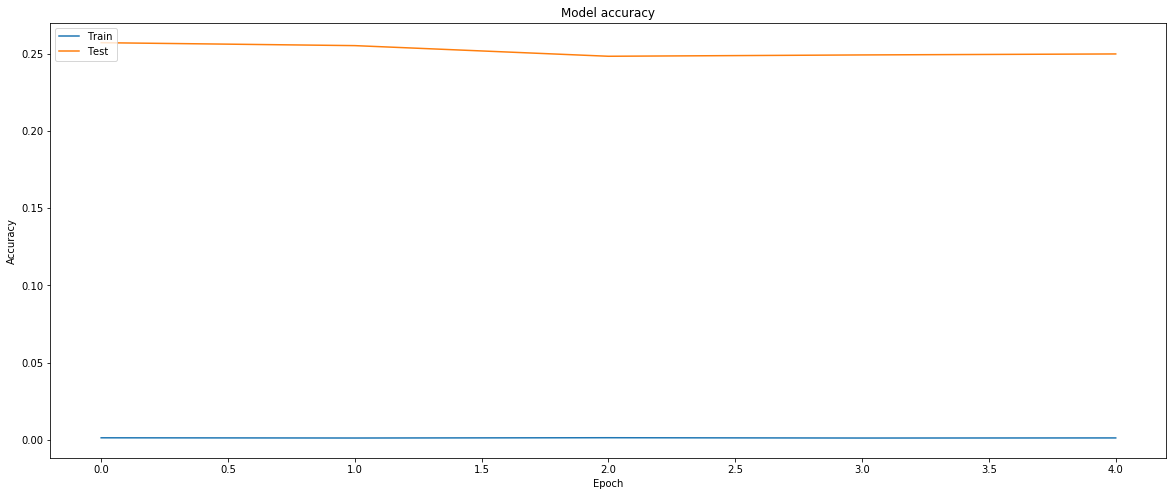

In [0]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-ml_knn_word_estimators['train_score'])
ax.plot(-ml_knn_word_estimators['test_score'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')

##Random forest

In [0]:
%%time

ml_rf_word_model = RandomForestRegressor(n_jobs=16,min_samples_leaf=2, max_depth =3,n_estimators=5)
ml_rf_word_estimators = cross_validate(ml_rf_word_model, word_ml_predictions_train, y_train*2+1, cv=5,return_estimator=True,return_train_score=True,scoring='neg_mean_squared_error')
best_estimator = np.argmax(ml_rf_word_estimators['test_score'])
word_ml_rf_predictions = ml_rf_word_estimators['estimator'][best_estimator].predict(word_ml_predictions_test)

y_t_rf=y_test*2+1

word_mae_rf = np.absolute((y_t_rf-np.array(word_ml_rf_predictions*2+1))).mean()
word_rmse_rf = math.sqrt(((y_t_rf-np.array(word_ml_rf_predictions*2+1))**2).mean())

print("RANDOM MAE: %.3f" %word_mae_rf)
print("RANDOM RMSE: %.3f" %word_rmse_rf)


RANDOM MAE: 3.384
RANDOM RMSE: 3.438
CPU times: user 530 ms, sys: 132 ms, total: 662 ms
Wall time: 28.3 s


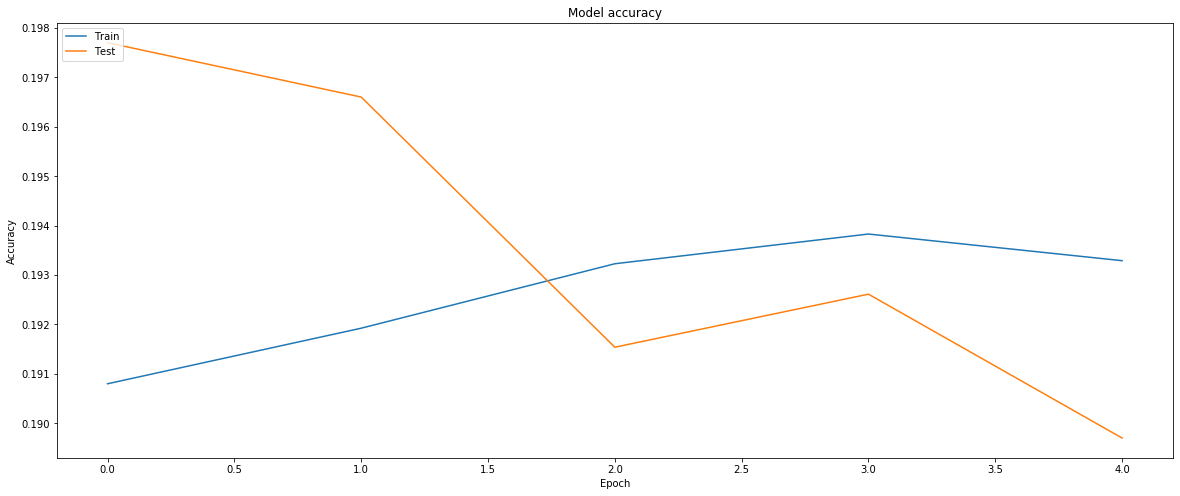

In [0]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
ax.plot(-ml_rf_word_estimators['train_score'])
ax.plot(-ml_rf_word_estimators['test_score'])
ax.set_title('Model Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='upper left')